# Create a regular gridded dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import verde as vd
import harmonica as hm
import pyproj
from pathlib import Path
import tarfile
from io import StringIO

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Crop survey area

In [3]:
tar_path = Path('../data/1038_XYZ.tar.xz')
file_path = Path('1038_XYZ/1038/spaulo_rjaneiro_rj.xyz')
file_content = None
with tarfile.open(tar_path, 'r') as tar:
    for member in tar.getmembers():
        if Path(member.name) == file_path:
            file_content = tar.extractfile(member).read().decode('ISO-8859-1')
            break
if file_content is None:
    raise FileNotFoundError(f"The specified file '{file_path}' was not found in the tar archive.")

lines = file_content.splitlines()
filtered_lines = [line for line in lines if not (line.startswith('LINE') or line.startswith('TIE'))]
filtered_data = '\n'.join(filtered_lines)
filtered_data_io = StringIO(filtered_data)

column_names = [
    'easting_m', 'northing_m', 'longitude', 'latitude', 'tfa_nT', 'THC', 'UC', 'KC', 'CTC', 
    'MAGB', 'MAGC', 'MAGD', 'THB', 'UB', 'KB', 'CTB', 'FIDU', 'TEMP', 
    'height_m', 'ALTB'
]
use_columns = [
    'longitude', 'latitude', 'tfa_nT', 'height_m',
]
df = pd.read_csv(filtered_data_io, 
                 delim_whitespace=True,
                 names=column_names,
                 usecols=use_columns,
                 skiprows=6)
df

,longitude,latitude,tfa_nT,height_m
0,-43.995255,-23.099503,434.32,300.00
1,-43.995224,-23.098618,426.28,300.00
2,-43.995193,-23.097733,418.24,300.00
3,-43.995178,-23.096832,410.20,300.00
4,-43.995148,-23.095947,402.16,300.00
...,...,...,...,...
433231,-41.949890,-20.818878,184.03,241.71
433232,-41.950882,-20.818909,179.13,241.10
433233,-41.951859,-20.818909,174.23,238.66
433234,-41.952850,-20.818924,167.32,234.70


In [4]:
# Crop area
# region = [-42.9, -42.0, -22.6, -22.0]
region = [-42.65, -41.95, -22.6, -21.8]
mask = vd.inside(coordinates=[df.longitude, df.latitude], region=region)
data = df[mask]

In [5]:
# Project coordinates
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
easting, northing = projection(data.longitude.values, data.latitude.values)
coordinates = [easting, northing, data.height_m]

data = data.assign(easting_m=easting)
data = data.assign(northing_m=northing)
data

,longitude,latitude,tfa_nT,height_m,easting_m,northing_m
147751,-42.645248,-22.599152,192.10,192.94,-4.397547e+06,-2.378091e+06
147752,-42.645264,-22.598267,192.04,177.39,-4.397549e+06,-2.377993e+06
147753,-42.645279,-22.597366,192.98,161.85,-4.397550e+06,-2.377893e+06
147754,-42.645309,-22.596481,191.92,146.91,-4.397554e+06,-2.377795e+06
147755,-42.645325,-22.595581,189.86,134.72,-4.397555e+06,-2.377695e+06
...,...,...,...,...,...,...
424445,-41.954041,-21.802902,87.69,300.00,-4.326271e+06,-2.289916e+06
424446,-41.953125,-21.802902,87.64,300.00,-4.326176e+06,-2.289916e+06
424447,-41.952209,-21.802902,87.59,300.00,-4.326082e+06,-2.289916e+06
424448,-41.951294,-21.802902,88.54,300.00,-4.325987e+06,-2.289916e+06


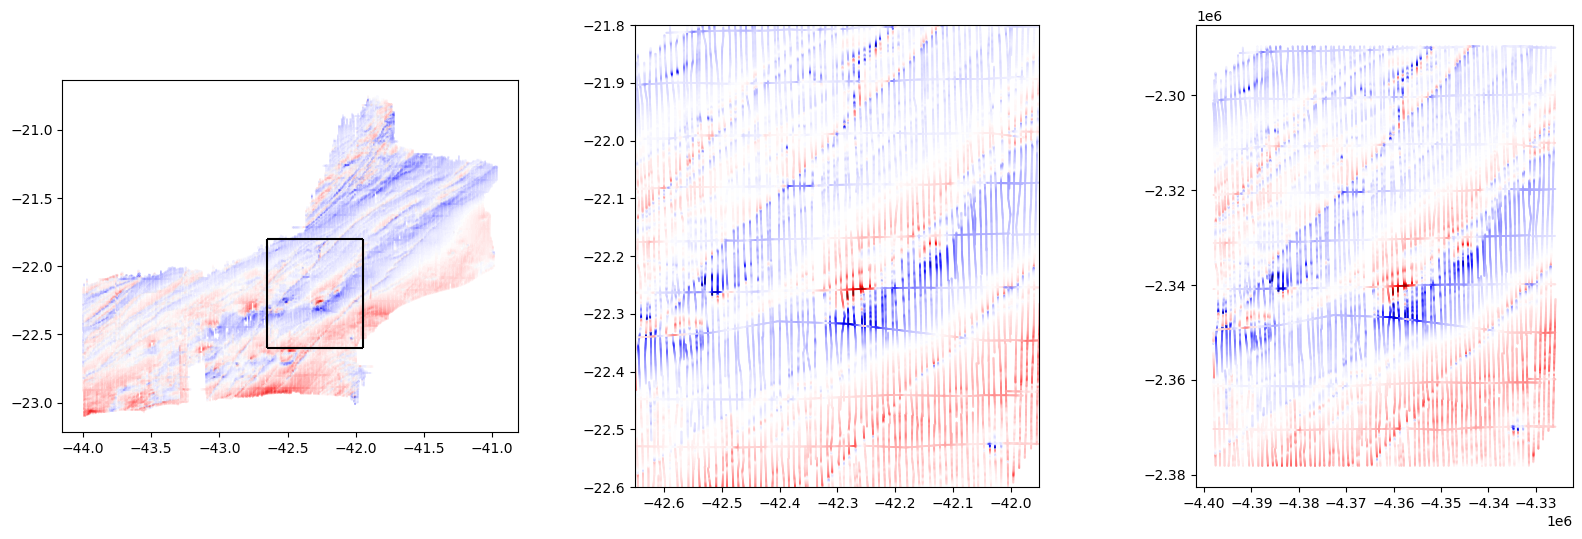

In [6]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.scatter(df.longitude, df.latitude, s=0.001, c=df.tfa_nT, cmap='seismic')
plt.axis('scaled')
plt.vlines(x=[region[0], region[1]], ymin=region[2], ymax=region[3], color='black')
plt.hlines(y=[region[2], region[3]], xmin=region[0], xmax=region[1], color='black')
plt.subplot(1,3,2)
plt.scatter(data.longitude, data.latitude, s=0.1, c=data.tfa_nT, cmap='seismic')
plt.axis('scaled')
plt.xlim(region[0], region[1])
plt.ylim(region[2], region[3])
plt.subplot(1,3,3)
plt.scatter(data.easting_m, data.northing_m, s=0.1, c=data.tfa_nT, cmap='seismic')
plt.axis('scaled')
plt.show()

## Interpolate data onto a regular grid using GB EQS

In [7]:
damping = 1
depth = 2e3
grid_spacing = 0.1e3

eqs = hm.EquivalentSourcesGB(
    depth=depth,
    damping=damping,
    block_size=grid_spacing,
    window_size=20e3,
    random_state=0,
)

In [8]:
eqs.fit(coordinates, data.tfa_nT)

EquivalentSourcesGB(block_size=100.0, damping=1, depth=2000.0, random_state=0,
                    window_size=20000.0)

In [9]:
grid_region = vd.get_region(coordinates)
grid_coords = vd.grid_coordinates(
    region=grid_region,
    spacing=grid_spacing,
    extra_coords=data.height_m.max(),
)
grid_tfa_nT = eqs.predict(grid_coords)

In [10]:
grid_data = vd.make_xarray_grid(grid_coords, data=grid_tfa_nT, data_names="tfa_nT", dims=('northing_m', 'easting_m'), extra_coords_names='height_m')
grid_data

<xarray.Dataset> Size: 10MB
Dimensions:     (northing_m: 887, easting_m: 723)
Coordinates:
  * easting_m   (easting_m) float64 6kB -4.398e+06 -4.398e+06 ... -4.326e+06
  * northing_m  (northing_m) float64 7kB -2.378e+06 -2.378e+06 ... -2.29e+06
    height_m    (northing_m, easting_m) float64 5MB 300.0 300.0 ... 300.0 300.0
Data variables:
    tfa_nT      (northing_m, easting_m) float64 5MB 182.2 182.5 ... 76.96 76.31

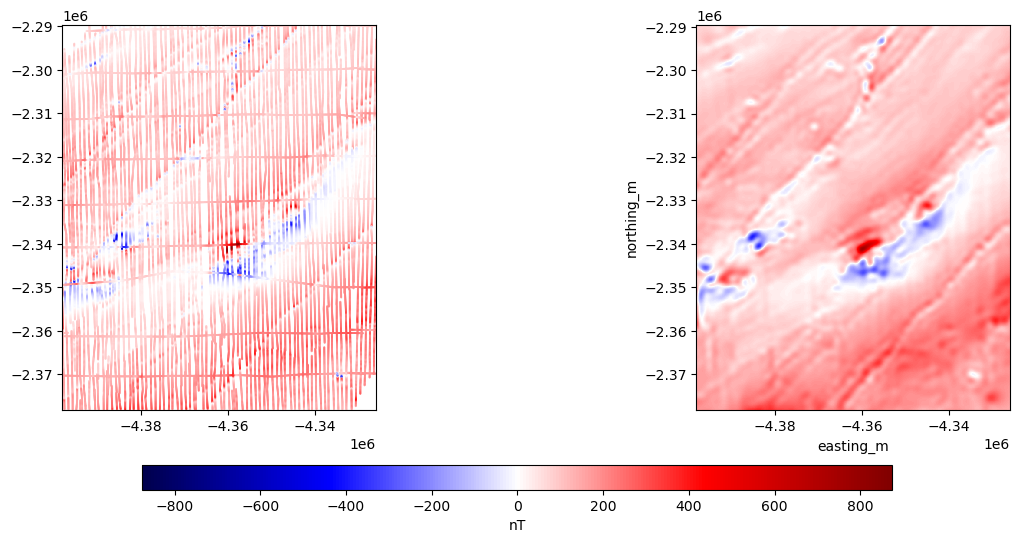

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.ravel()
ax = axes[0]
scale = vd.maxabs(data.tfa_nT)
ax.scatter(
    data.easting_m,
    data.northing_m,
    c=data.tfa_nT,
    s=0.1,
    cmap="seismic",
    vmin=-scale,
    vmax=scale,
)
ax.set_xlim(grid_region[0], grid_region[1])
ax.set_ylim(grid_region[2], grid_region[3])
ax.set_aspect("equal")

ax = axes[1]
tmp = grid_data.tfa_nT.plot.pcolormesh(
    cmap="seismic",
    vmin=-scale,
    vmax=scale,
    add_colorbar=False,
)
ax.set_aspect("equal")
cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.05, shrink=0.9)
fig.colorbar(tmp, **cbar_kwargs,  label="nT", cax=fig.add_axes([0.25, -0.05, 0.5, 0.05]))
plt.show()

### 2 EQS layers

In [18]:
deep_damping = 1
deep_depth = 2e3
grid_spacing = 0.1e3

deep_layer = hm.EquivalentSourcesGB(
    depth=deep_depth,
    damping=deep_damping,
    block_size=grid_spacing,
    window_size=20e3,
    random_state=0,
)
deep_layer.fit(coordinates, data.tfa_nT)
deep_tfa = eqs.predict(coordinates)
deep_residual = data.tfa_nT - deep_tfa

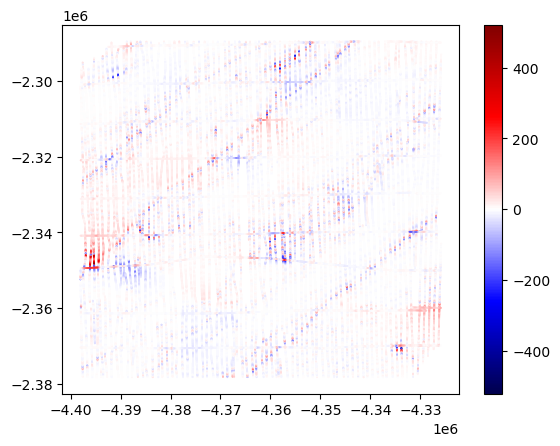

In [19]:
scale = vd.maxabs(deep_residual)
plt.figure()
plt.scatter(coordinates[0], coordinates[1], c=deep_residual, cmap="seismic", s=0.1, vmin=-scale, vmax=scale)
plt.colorbar()
plt.show()

In [20]:
shallow_damping = 1e3
shallow_depth = 0.5e3
shallow_layer = hm.EquivalentSourcesGB(
    depth=shallow_depth,
    damping=shallow_damping,
    block_size=grid_spacing,
    window_size=20e3,
    random_state=0,
)
shallow_layer.fit(coordinates, deep_residual)
tfa_predict = deep_layer.predict(grid_coords) + shallow_layer.predict(grid_coords)

In [21]:
tfa_two_layers = vd.make_xarray_grid(grid_coords, data=tfa_predict, data_names="tfa_nT", dims=('northing_m', 'easting_m'), extra_coords_names='height_m')

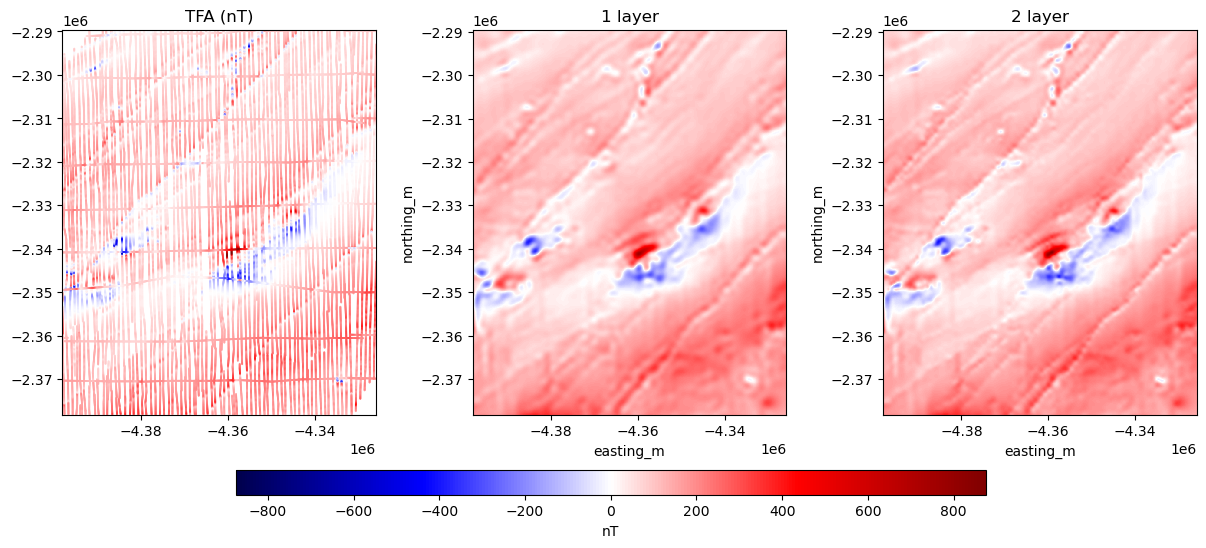

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.ravel()
ax = axes[0]
scale = vd.maxabs(data.tfa_nT)
ax.scatter(
    data.easting_m,
    data.northing_m,
    c=data.tfa_nT,
    s=0.1,
    cmap="seismic",
    vmin=-scale,
    vmax=scale,
)
ax.set_xlim(grid_region[0], grid_region[1])
ax.set_ylim(grid_region[2], grid_region[3])
ax.set_aspect("equal")
ax.set_title('TFA (nT)')

ax = axes[1]
tmp = grid_data.tfa_nT.plot.pcolormesh(
    ax=ax,
    cmap="seismic",
    vmin=-scale,
    vmax=scale,
    add_colorbar=False,
)
ax.set_aspect("equal")
ax.set_title('1 layer')

ax = axes[2]
tmp1 = tfa_two_layers.tfa_nT.plot.pcolormesh(
    ax=ax,
    cmap="seismic",
    vmin=-scale,
    vmax=scale,
    add_colorbar=False,
)
ax.set_aspect("equal")
ax.set_title('2 layer')
cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.05, shrink=0.9)
fig.colorbar(tmp, **cbar_kwargs,  label="nT", cax=fig.add_axes([0.25, -0.05, 0.5, 0.05]))
plt.show()

## Save data

In [17]:
# data_path = Path('../data/rio-magnetic.nc') 
# grid_data.to_netcdf(data_path)